# Disease Symptoms Prediction Model

## Introduction:

The primary objective is to use the symptoms data to predict the associated disease using a classification model. By understanding the correlation between symptoms and diseases, healthcare professionals can make more informed decisions and provide timely intervention.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import resample
from scipy.stats import chi2_contingency
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

## Acquire

### Dataset 1

In [2]:
df = pd.read_csv('symptoms.csv', sep='\t', header=None, names=['Disease', 'Symptom'], index_col=0)

In [3]:
df.head()

,Symptom
Disease,
"hypertensive disease,pain chest",NaN
"hypertensive disease,shortness of breath",NaN
"hypertensive disease,dizziness",NaN
"hypertensive disease,asthenia",NaN
"hypertensive disease,fall",NaN


## Prepare:

#### Dataset Structure:

- **Rows**: 1866
- **Columns**: 2
- **Columns**: Disease, Symptom

In [4]:
# Split the index and create two new columns
df['Disease'], df['Symptom'] = zip(*df.index.str.split(','))

# Reset the index
df.reset_index(drop=True, inplace=True)

# Reorder columns
df = df[['Disease', 'Symptom']]

df.head()

,Disease,Symptom
0,hypertensive disease,pain chest
1,hypertensive disease,shortness of breath
2,hypertensive disease,dizziness
3,hypertensive disease,asthenia
4,hypertensive disease,fall


In [5]:
df = df.drop_duplicates(subset=['Disease', 'Symptom'])
df.shape

(1831, 2)

## Dataset 2

In [6]:
df = pd.read_csv('dataset.csv')

In [7]:
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Fungal infection,itching,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Fungal infection,skin_rash,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fungal infection,itching,nodal_skin_eruptions,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Fungal infection,itching,skin_rash,dischromic _patches,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fungal infection,itching,skin_rash,nodal_skin_eruptions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Melt the dataframe
df = df.melt(id_vars=['Disease'], value_name='Symptom')

# Remove rows with NaN values in the Symptom column
df.dropna(subset=['Symptom'], inplace=True)

# Drop the variable column as it's not needed
df.drop(columns=['variable'], inplace=True)
df.head()

,Disease,Symptom
0,Fungal infection,itching
1,Fungal infection,skin_rash
2,Fungal infection,itching
3,Fungal infection,itching
4,Fungal infection,itching


## Explore

In [9]:
# Split the data into training, validation, and testing sets
# First, we split the data into training (60%) and temporary (40%)
train, temp = train_test_split(df, test_size=0.3, random_state=42)

# Now, split the temporary set into validation (20%) and test sets (20%)
val, test = train_test_split(temp, test_size=0.5, random_state=42)
train.shape, val.shape, test.shape

((25653, 2), (5497, 2), (5498, 2))

**Question 1:** What is the distribution of diseases in the dataset?

**Visualization:** Create a bar plot of the disease occurrences.

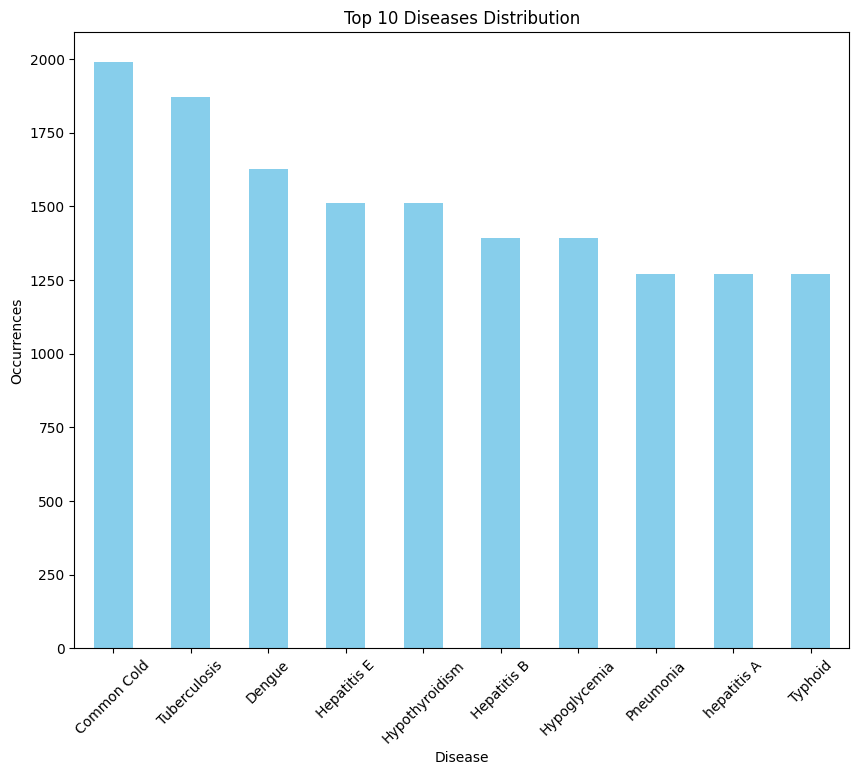

In [10]:
# Visualization - Bar Plot for Disease Distribution
plt.figure(figsize=(10, 8))
df['Disease'].value_counts().head(10).plot(kind='bar', color='skyblue')  # Displaying top 10 diseases for clarity
plt.title('Top 10 Diseases Distribution')
plt.xlabel('Disease')
plt.ylabel('Occurrences')
plt.xticks(rotation=45)
plt.show()

**Question 2:** Which symptoms are most common across all diseases?

**Visualization:** Create a bar plot of the most common symptoms.

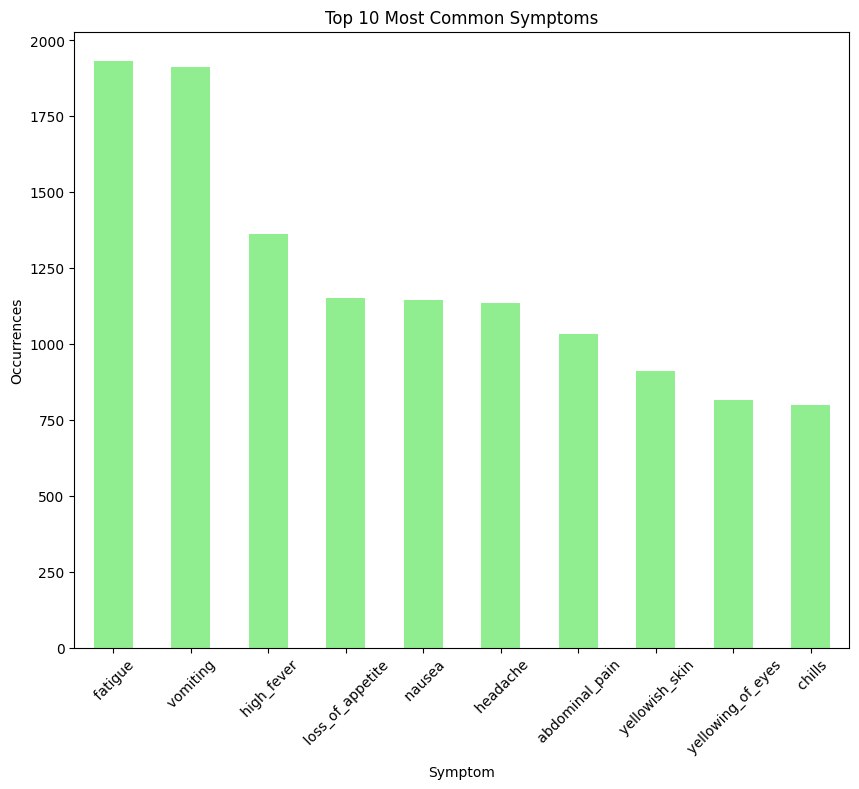

In [11]:
# Visualization - Bar Plot for Symptoms Distribution
plt.figure(figsize=(10, 8))
df['Symptom'].value_counts().head(10).plot(kind='bar', color='lightgreen')
plt.title('Top 10 Most Common Symptoms')
plt.xlabel('Symptom')
plt.ylabel('Occurrences')
plt.xticks(rotation=45)
plt.show()

**Question 3:** For a specific disease (e.g., hypertensive disease), what are the most commonly reported symptoms?

**Visualization:** Create a bar plot of the most common symptoms for the chosen disease.

# Filtering data for hypertensive disease
disease_specific = df[df['Disease'] == 'hypertensive disease']

# Visualization - Bar Plot for Symptoms of the hypertensive disease
plt.figure(figsize=(10, 8))
disease_specific['Symptom'].value_counts().plot(kind='bar', color='salmon')
plt.title('Symptoms for Hypertensive Disease')
plt.xlabel('Symptom')
plt.ylabel('Occurrences')
plt.xticks(rotation=45)
plt.show()

In [12]:
# Label Encoding
label_encoders = {}

# Encoding 'Disease'
disease_encoder = LabelEncoder()
df['Disease_encoded'] = disease_encoder.fit_transform(df['Disease'])
label_encoders['Disease'] = disease_encoder

In [13]:
# Encoding 'Symptom'
symptom_encoder = LabelEncoder()
df['Symptom_encoded'] = symptom_encoder.fit_transform(df['Symptom'])
label_encoders['Symptom'] = symptom_encoder

# Checking distribution of 'Disease' for balancing
disease_counts = df['Disease_encoded'].value_counts()

In [14]:
# Identify the majority class
majority_class = disease_counts.idxmax()

# Separate majority and minority classes
df_majority = df[df.Disease_encoded == majority_class]
df_minority = df[df.Disease_encoded != majority_class]

In [15]:
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True, 
                                 n_samples=disease_counts[majority_class],
                                 random_state=42) 

# Combine majority class with upsampled minority class
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Display the balanced dataset distribution
print(df_balanced['Disease_encoded'].value_counts())

Disease_encoded
10    1992
36     107
25     100
11      95
19      94
22      89
26      87
8       72
37      71
30      68
24      66
21      65
40      63
28      63
12      61
34      58
29      51
0       49
9       47
35      47
3       47
6       40
31      40
39      39
33      35
20      35
23      33
15      31
7       31
2       31
18      29
13      29
27      29
14      25
16      25
4       25
5       25
38      24
32      24
17      23
1       19
Name: count, dtype: int64


In [16]:
# Identify the majority class count
majority_count = df['Disease_encoded'].value_counts().max()

In [17]:
# Separate data by Disease_encoded and upsample each minority class
dfs = []
for disease_code in df['Disease_encoded'].unique():
    disease_df = df[df['Disease_encoded'] == disease_code]
    resampled_df = resample(disease_df, 
                            replace=True, 
                            n_samples=majority_count, 
                            random_state=42)
    dfs.append(resampled_df)

In [18]:
# Concatenate the upsampled dfs
df_balanced = pd.concat(dfs)

# Display the balanced dataset distribution
print(df_balanced['Disease_encoded'].value_counts())

Disease_encoded
15    1992
20    1992
22    1992
3     1992
36    1992
10    1992
34    1992
13    1992
18    1992
39    1992
26    1992
24    1992
25    1992
31    1992
5     1992
0     1992
2     1992
38    1992
35    1992
21    1992
19    1992
4     1992
40    1992
16    1992
9     1992
14    1992
33    1992
1     1992
12    1992
17    1992
6     1992
23    1992
30    1992
7     1992
32    1992
28    1992
29    1992
8     1992
11    1992
37    1992
27    1992
Name: count, dtype: int64


## Modeling

In [19]:
# Encode the 'Symptom' column
encoder_symptom = LabelEncoder()
df['Symptom_encoded'] = encoder_symptom.fit_transform(df['Symptom'])

# Splitting the data again
X = df.drop(['Disease', 'Symptom', 'Disease_encoded'], axis=1)  # Using only 'Symptom_encoded' as features
y = df['Disease_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Create a dummy classifier that always predicts the class that maximizes the training set's class distribution
dummy_clf = DummyClassifier(strategy="most_frequent")

# Fit the classifier
dummy_clf.fit(X_train, y_train)

# Predict on the test set
baseline_predictions = dummy_clf.predict(X_test)

# Calculate the accuracy
baseline_accuracy = accuracy_score(y_test, baseline_predictions)

baseline_accuracy


0.05579809004092769

In [21]:
# Initialize and train the model
log_reg = LogisticRegression(max_iter=10000)  # Increase max_iter for convergence
log_reg.fit(X_train, y_train)

# Predict on test set
log_reg_preds = log_reg.predict(X_test)

# Evaluate the model
log_reg_accuracy = accuracy_score(y_test, log_reg_preds)
log_reg_accuracy

0.05757162346521146

In [22]:
# Initialize and train the model
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

# Predict on test set
decision_tree_preds = decision_tree.predict(X_test)

# Evaluate the model
decision_tree_accuracy = accuracy_score(y_test, decision_tree_preds)
decision_tree_accuracy

0.3813096862210095

In [23]:
# Initialize and train the model
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train, y_train)

# Predict on test set
random_forest_preds = random_forest.predict(X_test)

# Evaluate the model
random_forest_accuracy = accuracy_score(y_test, random_forest_preds)
random_forest_accuracy

0.3814461118690314

In [24]:
# Initialize and train the model
knn = KNeighborsClassifier(n_neighbors=5)  # Default number of neighbors is 5
knn.fit(X_train, y_train)

# Predict on test set
knn_preds = knn.predict(X_test)

# Evaluate the model
knn_accuracy = accuracy_score(y_test, knn_preds)
knn_accuracy

0.40641200545702594